# Import

In [36]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [37]:
#import data and subset meaningful columns
df = pd.read_csv('/Users/zachstone/notebooks/modulargrid/modulargrid_scrape-main/modules.csv')
df = df[['manufacturer_name', 
         'module_name', 
         'module_type',
         'width',
         'depth',
         'current_plus12V','current_minus12V','current_5V',
         'price',
         'num_racks',
         'tags',
         'availability']]

In [70]:
# #subset eurorack modules
moduledf = df[df.module_type == 'eurorack']
moduledf.drop('module_type', axis =1, inplace=True)
moduledf['tags'] = moduledf['tags'].str.lower()

# Inspect data

## Classifying missing data

In [39]:
moduledf.isna().sum()
#missing current and depth info OK
#tags and price are important factors

manufacturer_name       0
module_name             0
width                   0
depth                3256
current_plus12V      3694
current_minus12V     4314
current_5V           6107
price                2402
num_racks               0
tags                   71
availability            0
dtype: int64

In [40]:
#Check the types of modules which are missing prices
moduledf[moduledf.price.isnull()].groupby('tags').size().sort_values(ascending=False)

tags
blank panel                                               179
filter                                                     89
oscillator                                                 83
drum                                                       81
utility                                                    65
                                                         ... 
delay-filter                                                1
delay-filter-low pass gate-mixer-oscillator-random-vca      1
delay-filter-synth voice                                    1
delay-lfo                                                   1
waveshaper-utility                                          1
Length: 891, dtype: int64

In [41]:
# many are blank panels (for filling space, not devices). These can be dropped.
moduledf = moduledf[moduledf.tags != 'blank panel']

In [71]:
# moduledf[moduledf.price.isnull()].groupby('availability').size().sort_values(ascending=False).plot(kind='barh')
#many are unavailable or prototypes

In [72]:
#find out if items with missing price are popular
# moduledf[moduledf.price.isnull()].sort_values(ascending=False, by = 'num_racks')

In [73]:
#Some of the parts with missing price are just power supplies, or expanders (optional modules which come packaged with another)
#These can be dropped
moduledf['accessory_flag'] = moduledf['tags'].str.contains('power|expander|blank panel')
moduledf = moduledf[moduledf.accessory_flag == False].drop('accessory_flag',axis=1)

#Re-check for popular items with missing price
# moduledf[moduledf.price.isnull()].sort_values(ascending=False, by = 'num_racks').head(20)
#9 of the top 20 popular devices with missing devices are prototypes or unavailable, restrict attention to available devices

In [75]:
moduledf.loc[:,'brand_known'] = moduledf.manufacturer_name.apply(lambda x: x != 'Other/unknown')
# moduledf[moduledf.price.isnull()].groupby('brand_known').size()
#and about half come from unknown brands

In [74]:
# moduledf.price.isnull().sum() / len(moduledf) * 100

In [47]:
df_brands = moduledf.loc[(moduledf.brand_known == True) & moduledf.availability.isin(['unknown','avail'])]
# df_brands.price.isnull().sum() / len(df_brands) * 100
#about 10% of price data is missing for products from main brands for non-prototype/unavailable products

10.317011038777244

In [78]:
# df_brands[df_brands.price.isnull()].sort_values(by = 'num_racks', ascending=False).head(30)
#inspecing many of these manually, most are replicas or units which have been replaced by newer versions
#For example, Grayscale seems to mostly produce homemade remakes 

In [79]:
# df_brands[df_brands.price.isnull()].groupby('manufacturer_name').size().sort_values(ascending=False).head(15)

In [80]:
# moduledf[moduledf.manufacturer_name == 'Grayscale']; #ex: grayscale products are remakes with different face plates

In [81]:
# moduledf[moduledf.manufacturer_name == 'Barton Musical Circuits']; #grayscale products are remakes with different face plates

# EDA
modulesdf contains all eurorack modules, even without brand name, with 'accessories' (blank panels, power strips, expanders) dropped. About 20% of all modules are missing price.

brand_df is the subset for modules with brand names listed. About 10% of prices are missing for branded modules.

Some useful but non-obvious business questions: 
1) What functions are optimal for single-use modules? What are their optimal sizes and pricings?
2) What functions are optimal for multi-use modules? What are their optimal sizes and pricings?
3) What are good choices for combinations of functions for multi-use modules? Are certain groupings more popular at certain sizes? What price points are good for that?
4) What 'gaps' might exist for multi-use modules? E.g. popular functions at that size and price point.

These will have to be broken up. We should look at:
-general correlations

a) popularity of different types

b) size distribution of different types

c) price vs popularity

d) for each type, to what extent does price vs size vs brand vs combos predict popularity

## Prep

In [52]:
#subset eurorack modules
moduledf = df[df.module_type == 'eurorack']
moduledf.drop('module_type', axis =1, inplace=True)
# moduledf['tags'] = moduledf['tags'].str.lower()

#Drop accessories
moduledf['accessory_flag'] = moduledf['tags'].str.contains('power|expander|blank panel')
moduledf = moduledf[moduledf.accessory_flag == False].drop('accessory_flag',axis=1)

#Flag unknown brands
moduledf.loc[:,'brand_known'] = moduledf.manufacturer_name.apply(lambda x: x != 'Other/unknown')

#Get branded modules
df_brands = moduledf.loc[(moduledf.brand_known == True) & moduledf.availability.isin(['unknown','avail'])]


#Make dfs exploded over function
df_brands['functions'] = df_brands.tags.str.split('-')
brands_exploded = df_brands.explode('functions')

#Multi vs. single function flag
df_brands['multifunction'] = df_brands['functions'].apply(lambda x: len(x)>1)



# moduledf['functions'] = moduledf.tags.str.split('-')
# modules_exploded = moduledf.explode('functions')

/var/folders/g3/v_62hrbj20d1z2xt6c246v780000gn/T/ipykernel_317/2234960078.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_brands['functions'] = df_brands.tags.str.split('-')
/var/folders/g3/v_62hrbj20d1z2xt6c246v780000gn/T/ipykernel_317/2234960078.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_brands['multifunction'] = df_brands['functions'].apply(lambda x: len(x)>1)


## EDA Q1: What types of modules are the most popular? 
A module will count as a particular category if it has that function. For example, multifunction modules will be counted in every category they are contained in.

<AxesSubplot:ylabel='functions'>

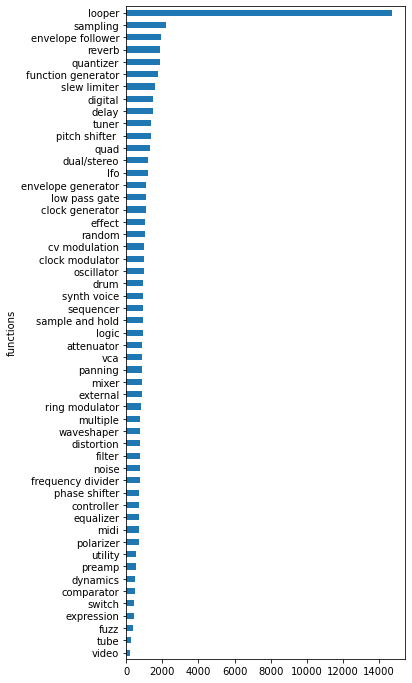

In [53]:
brands_exploded.groupby('functions')['num_racks'].mean().sort_values().plot(kind='barh', figsize = (5,12))

In [54]:
# modules_exploded.groupby('functions')['num_racks'].mean().sort_values().plot(kind='barh', figsize = (5,12))

In [55]:
brands_exploded.groupby('functions')['num_racks'].mean().sort_values(ascending=False).index

Index(['looper', 'sampling', 'envelope follower', 'reverb', 'quantizer',
       'function generator', 'slew limiter', 'digital', 'delay', 'tuner',
       'pitch shifter ', 'quad', 'dual/stereo', 'lfo', 'envelope generator',
       'low pass gate', 'clock generator', 'effect', 'random', 'cv modulation',
       'clock modulator', 'oscillator', 'drum', 'synth voice', 'sequencer',
       'sample and hold', 'logic', 'attenuator', 'vca', 'panning', 'mixer',
       'external', 'ring modulator', 'multiple', 'waveshaper', 'distortion',
       'filter', 'noise', 'frequency divider', 'phase shifter', 'controller',
       'equalizer', 'midi', 'polarizer', 'utility', 'preamp', 'dynamics',
       'comparator', 'switch', 'expression', 'fuzz', 'tube', 'video'],
      dtype='object', name='functions')

In [56]:
brands_exploded.groupby('functions')['num_racks'].mean().sort_values(ascending=False).index

Index(['looper', 'sampling', 'envelope follower', 'reverb', 'quantizer',
       'function generator', 'slew limiter', 'digital', 'delay', 'tuner',
       'pitch shifter ', 'quad', 'dual/stereo', 'lfo', 'envelope generator',
       'low pass gate', 'clock generator', 'effect', 'random', 'cv modulation',
       'clock modulator', 'oscillator', 'drum', 'synth voice', 'sequencer',
       'sample and hold', 'logic', 'attenuator', 'vca', 'panning', 'mixer',
       'external', 'ring modulator', 'multiple', 'waveshaper', 'distortion',
       'filter', 'noise', 'frequency divider', 'phase shifter', 'controller',
       'equalizer', 'midi', 'polarizer', 'utility', 'preamp', 'dynamics',
       'comparator', 'switch', 'expression', 'fuzz', 'tube', 'video'],
      dtype='object', name='functions')

The above charts show that the branded modules are representative of all modules with respect to popularity of each function.

## EDA Q2: How do the popularity and price of single vs. multifunction modules compare for branded modules?

Text(0.5, 1.0, 'Multifunction vs. Popularity')

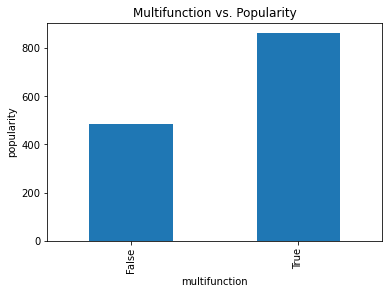

In [57]:
ax = df_brands.groupby('multifunction')['num_racks'].mean().plot(kind = 'bar') #multifunction modules are significantly more popular
ax.set_ylabel('popularity')
ax.set_title('Multifunction vs. Popularity')

Text(0.5, 1.0, 'Multifunction vs. Price')

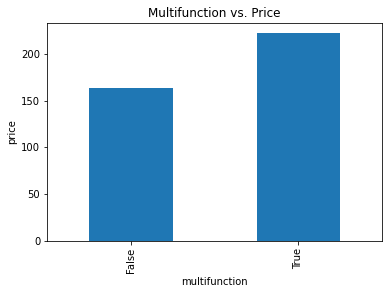

In [58]:
ax = df_brands.groupby('multifunction')['price'].mean().plot(kind='bar') #however, they are not significantly more expensive
ax.set_ylabel('price')
ax.set_title('Multifunction vs. Price')

## EDA Q3: What is the optimal size for each type of module to enhance popularity?

<AxesSubplot:xlabel='width', ylabel='num_racks'>

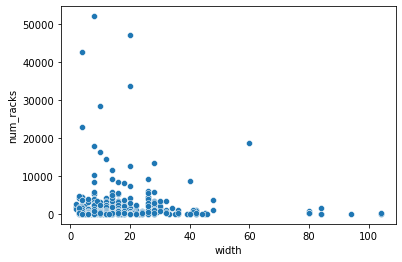

In [59]:
sns.scatterplot(x= 'width', y = 'num_racks', data = brands_exploded[brands_exploded.functions == 'lfo'])

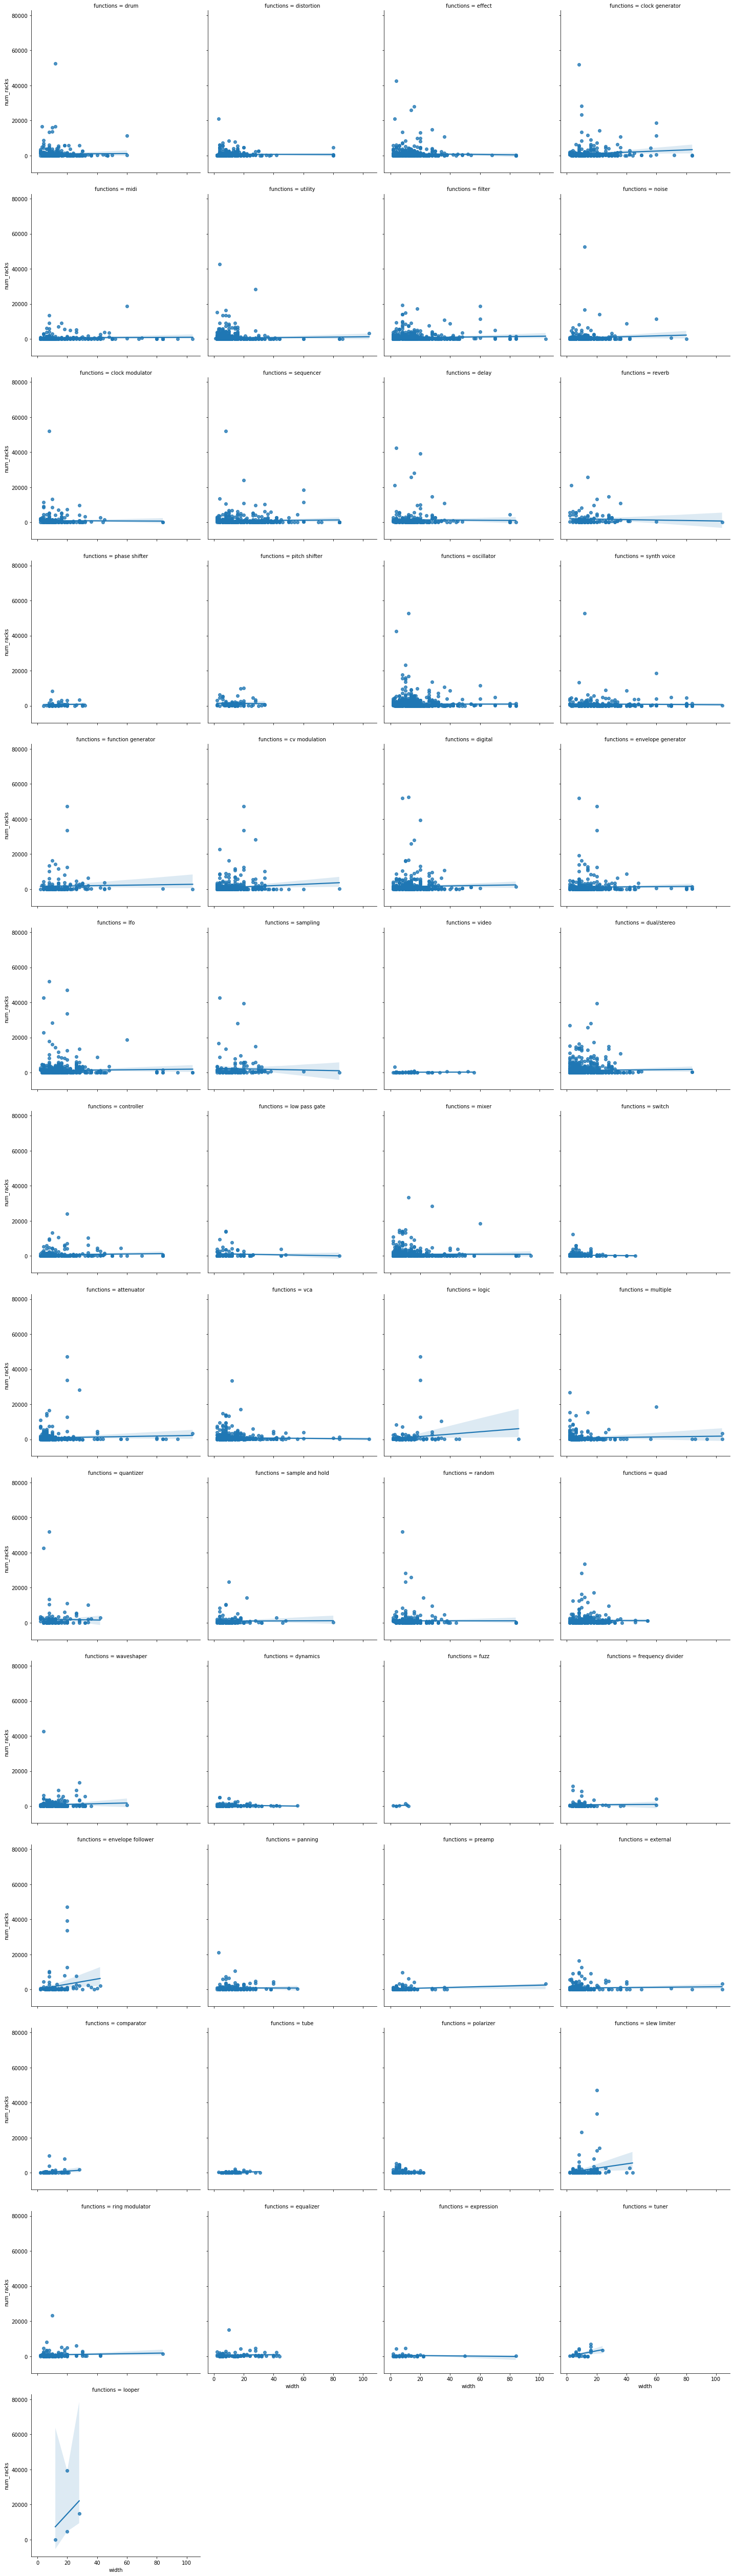

In [60]:
sns.lmplot(x = 'width', y = 'num_racks', data = brands_exploded, col = 'functions', col_wrap = 4)

As expected, the relationship between size and popularity is nonlinear, with popularity leaning towards mid-small sized modules.
To begin analysis of size, we look for size outliers in each category.

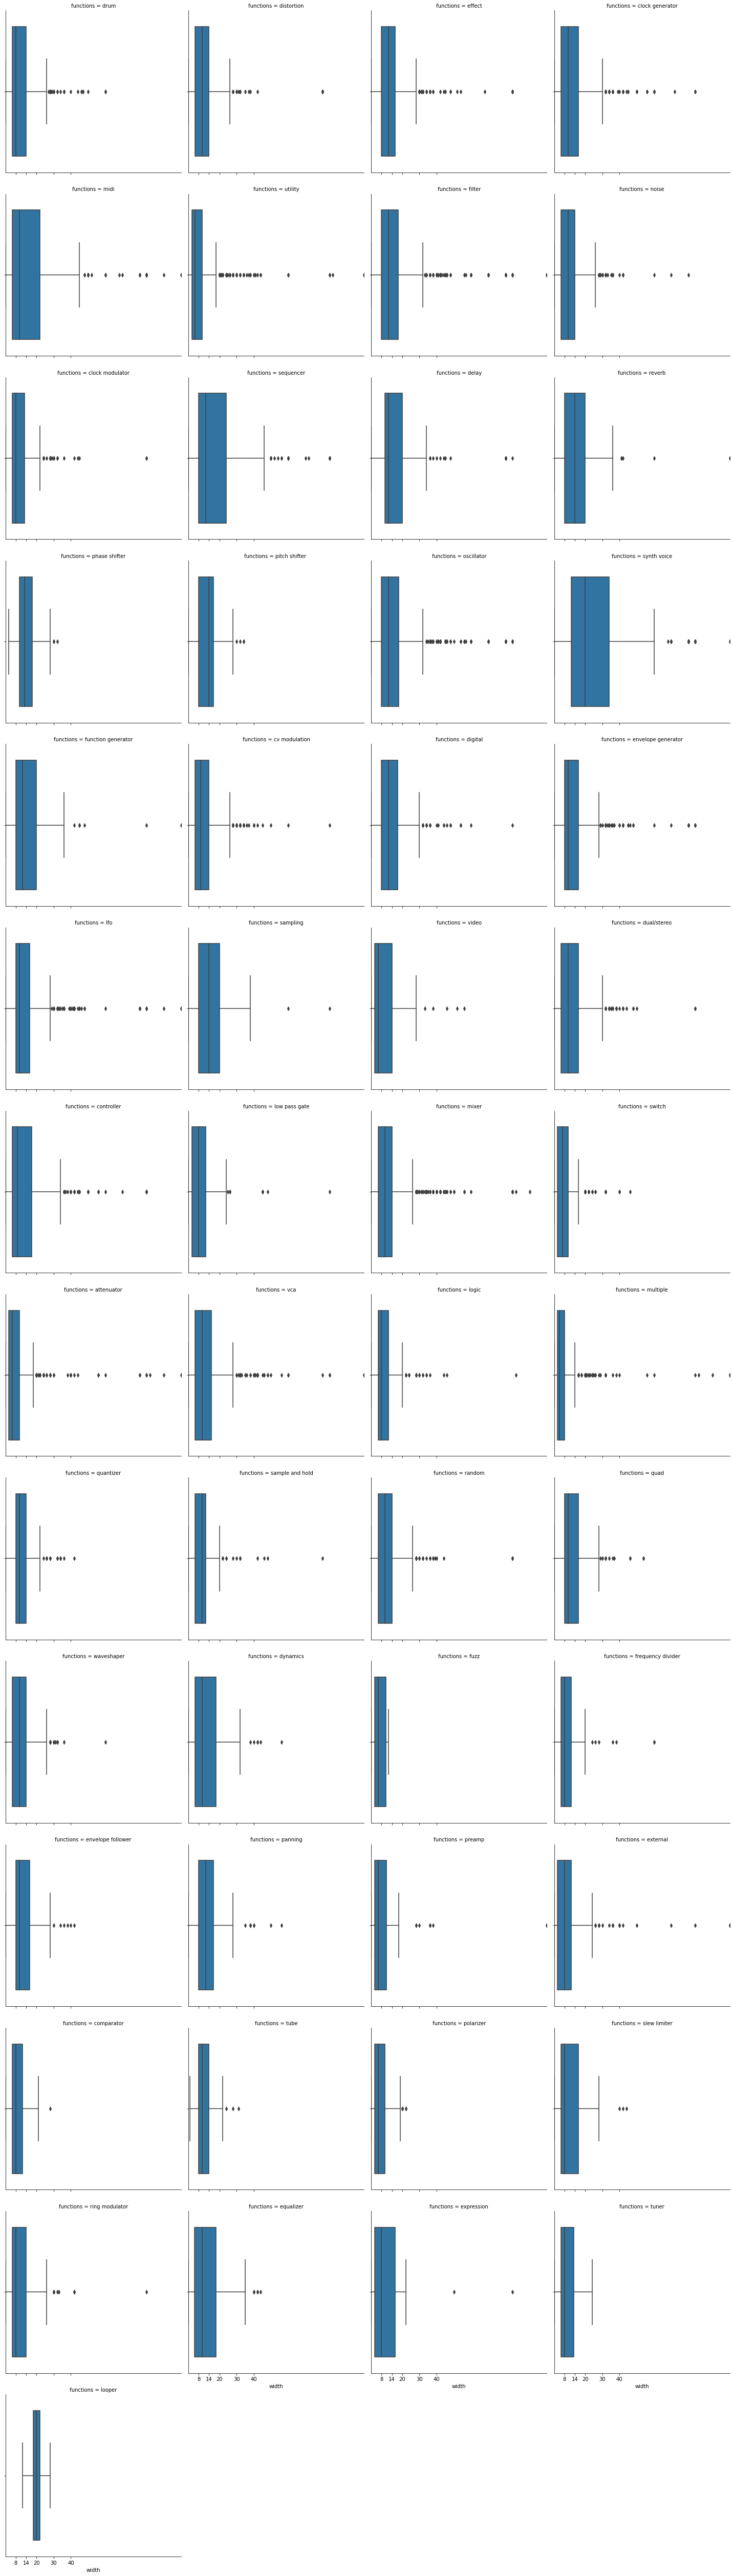

In [61]:
g = sns.catplot(x = 'width', col = 'functions', col_wrap = 4, data = brands_exploded, kind = 'box')
g.set(xlim = (2,np.max(brands_exploded.width)), xticks = [8, 14, 20, 30, 40])

The distribution of outliers over 1.5IQR above Q3 varies greatly between functions, suggesting that they may be different in each group. We should examine the outlier for each kind. This may be due to many factors, such as the outliers for certain functions being due to commonly being on multifunction modules, which may be larger.

In [62]:
def IQR(dist):
    return np.percentile(dist, 75) - np.percentile(dist, 25)

def cutoff(dist):
    return np.percentile(dist,75) + 1.5 * IQR(dist)

In [63]:
function_widths = [*brands_exploded.groupby('functions')['width']]

In [64]:
#Inspecting outliers for each group may be too complicated
# print(function_widths[0][0])
# print(cutoff(function_widths[0][1]))
# np.array(function_widths[0][1:]).reshape(-1,)[(function_widths[0][1] > cutoff(function_widths[0][1:])).values]

In [65]:
df_brands.groupby('multifunction')[['width']].agg([np.mean,np.std,IQR])

width                
                    mean        std  IQR
multifunction                           
False          10.109948   9.393301  8.0
True           11.982880  10.334958  8.0

In [66]:
df_brands[df_brands.price.notnull()].groupby('multifunction')[['width']].agg([np.mean,np.std,IQR])

width                
                    mean        std  IQR
multifunction                           
False          10.033776   9.288928  8.0
True           11.834253  10.168541  8.0

Single and multi-use modules have similar width distributions, with multifunction being larger by about 2hp.
We can check with a 2-sample ttest with p=0.05.

In [67]:
from scipy.stats import ttest_ind

In [68]:
multifunction_w = df_brands[df_brands.multifunction].loc[:,'width'].values
singlefunction_w = df_brands[~df_brands.multifunction].loc[:,'width'].values

In [69]:
ttest_ind(multifunction_w, singlefunction_w, equal_var = False, random_state = 53, alternative = 'greater')

Ttest_indResult(statistic=7.431973571153125, pvalue=6.412489290295425e-14)

However, the result is significant, so the overall 'target size' for each type are distinct.

## Price and popularity